In [1]:
# set width = 95%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [19]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, **kwargs):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
    if tight_layout==True:
        plt.tight_layout()
    elif tight_layout==False:
        pass
    else:
        plt.tight_layout(pad=tight_layout)
    plt.savefig(path, format=fig_extension, dpi=resolution,**kwargs)

# function to create histograms from a dataframe
#    attribute: column name to plot (iterates over list). Can contain numeric or boolean data
#    source_cols: one or more boolean columns. If one, splits into False and True categories.
#        otherwise, plots splits to categories: 1st column True, 2nd column True, etc.
#    labels: legend entries for each category
#    colors: edge color for each category
#    bins: histogram bins (list for each attribute)
#    save_suff: plots will be saved as "attribute" + save_suff + ".png"
# todo: allow single categorical series as source_cols
def split_hist(df,attribute,source_cols, labels=None, colors = None, bins=None, save_suff=""):
    # print("histogram for " + attribute.__str__())
    # loop over attributes
    if isinstance(attribute, list):
        for ind_att in range(0,len(attribute)):
            # currently, bins is the only parameter likely to vary by attribute
            if bins != None:
                bins_att = bins[ind_att]
            else:
                bins_att = None
            split_hist(df,attribute[ind_att],source_cols, labels=labels, colors = colors, bins=bins_att, save_suff=save_suff)
        return
    # collect indices for each category
    # cats membership by "True" in source columns
    if isinstance(source_cols, list):
        if len(source_cols)>10:
            raise ValueError("Too many categories to plot")
        idx_list = [df[x] for x in source_cols]
    # for single, boolean column, cats are [False,True]
    else:
        idx_list = [~df[source_cols],df[source_cols]]

    # for each category, plot a stair-type histogram
    for ind in range(0,len(idx_list)):
        if colors != None:
            color_arg = {'edgecolor':colors[ind]}
        else:
            color_arg = {'edgecolor':"C{}".format(ind)}
        # boolean attributes work slightly differently
        if df[attribute].dtype==np.dtype('bool'):
            tf_counts = df.loc[idx_list[ind],attribute].value_counts(normalize=True,sort=False)
            # problems if only False or only True
            if len(tf_counts) == 1:
                #tf_counts = pd.Series({tf_counts.index[0]:1.0,not tf_counts.index[0]:0.0})
                tf_counts = pd.Series({False:1.0-tf_counts.index[0],True:0.0+tf_counts.index[0]})
            tf_counts.plot(kind='bar',fill=False, linewidth=10-ind,**color_arg)
            plt.ylim(0,1)
        else:
            df.loc[idx_list[ind],attribute].hist(bins=bins,histtype='step', linewidth=10-ind, density = True,**color_arg)
    plt.legend(labels,loc='upper left')
    plt.title(attribute)
    save_fig(attribute + save_suff)
    plt.show()

In [3]:
!pip install heatmapz
from heatmap import heatmap, corrplot 

# Get the data

## Attribute Description
From Kaggle
- **GRE** Graduate Record Exam Scores
- **GPA** Grade Point Average
- **Rank** It refers to the prestige of the undergraduate institution.
The variable rank takes on the values 1 through 4. Institutions with a rank of 1 have the highest prestige, while those with a rank of 4 have the lowest.
- **Admit** It is a response variable; admit/don’t admit is a binary variable where 1 indicates that student is admitted and 0 indicates that student is not admitted.
- **SES** SES refers to socioeconomic status: 1 - low, 2 - medium, 3 - high.
- **Gendermale** Gendermale (0, 1) = 0 -> Female, 1 -> Male
- **Race** Race – 1, 2, and 3 represent Hispanic, Asian, and African-American

In [4]:
ADMIT_PATH = PROJECT_ROOT_DIR
def load_admissions_data(admit_path=ADMIT_PATH):
    csv_path = os.path.join(admit_path, "College_admission.csv")
    return pd.read_csv(csv_path)

In [5]:
admissions = load_admissions_data()
admissions.columns = ["admitted","GRE","GPA","socioeconomic_rank","gender_ismale","race_group","ugrad_prestige_rank"]
admissions.head()

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,race_group,ugrad_prestige_rank
0,0,380,3.61,1,0,3,3
1,1,660,3.67,2,0,2,3
2,1,800,4.00,2,0,2,1
3,1,640,3.19,1,1,2,4
4,0,520,2.93,3,1,2,4


In [6]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   admitted             400 non-null    int64  
 1   GRE                  400 non-null    int64  
 2   GPA                  400 non-null    float64
 3   socioeconomic_rank   400 non-null    int64  
 4   gender_ismale        400 non-null    int64  
 5   race_group           400 non-null    int64  
 6   ugrad_prestige_rank  400 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 22.0 KB


In [7]:
admissions.describe()

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,race_group,ugrad_prestige_rank
count,400.000000,400.000000,400.000000,400.000000,400.000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,1.992500,0.475,1.962500,2.48500
std,0.466087,115.516536,0.380567,0.808751,0.500,0.823279,0.94446
min,0.000000,220.000000,2.260000,1.000000,0.000,1.000000,1.00000
25%,0.000000,520.000000,3.130000,1.000000,0.000,1.000000,2.00000
50%,0.000000,580.000000,3.395000,2.000000,0.000,2.000000,2.00000
75%,1.000000,660.000000,3.670000,3.000000,1.000,3.000000,3.00000
max,1.000000,800.000000,4.000000,3.000000,1.000,3.000000,4.00000


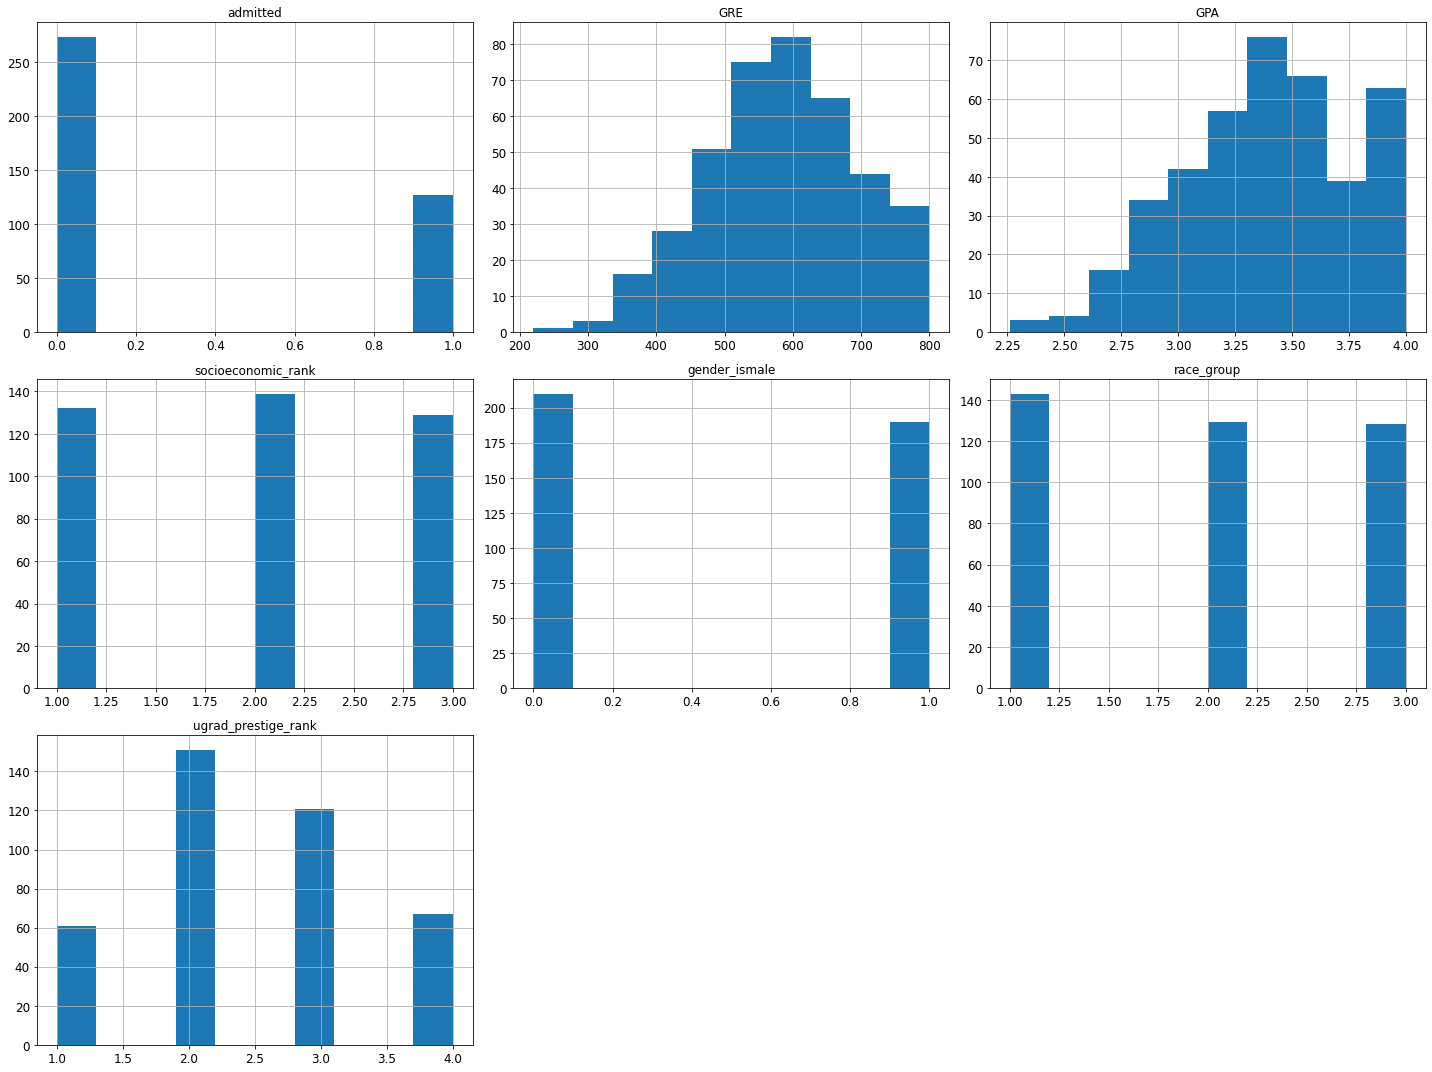

In [8]:
admissions.hist(figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Initial notes
- No null data; no clear n/a placeholder (zeros only appear in boolean attributes)
- variable ranges and values appear consistent with descriptions
- most attributes are discrete (e.g., no continuous school ranking)
- significant portion of GPA and GRE scores at max values

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(admissions, test_size=0.2, random_state=42)

# Deeper data exploration

In [10]:
admissions = test_set.copy()
# flip ugrad_prestige_rank to ascending
admissions["ugrad_prestige_rank"] = 5 - admissions["ugrad_prestige_rank"]
# split race into three columns
admissions["race_isHispanic"] = (admissions["race_group"]==1)
admissions["race_isAsian"] = (admissions["race_group"]==2)
admissions["race_isAA"] = (admissions["race_group"]==3)
# admitted and gender_ismale to boolean for consistency
admissions["gender_ismale"] = (admissions["gender_ismale"] == 1)
admissions["admitted"] = (admissions["admitted"] == 1)
admissions.drop("race_group", axis=1,inplace=True)
admissions.head()

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,ugrad_prestige_rank,race_isHispanic,race_isAsian,race_isAA
209,False,580,3.50,3,False,3,True,False,False
280,False,660,3.94,2,True,3,True,False,False
33,True,800,4.00,3,False,2,True,False,False
210,False,740,3.34,2,False,1,False,True,False
93,False,580,2.93,3,True,3,True,False,False


In [11]:
# from pandas.plotting import scatter_matrix
# attributes = admissions.columns
# scatter_matrix(admissions[attributes], figsize=(12, 8))
# save_fig("scatter_matrix_plot")
# note: no obvious gaps, but not a great visualization

In [12]:
# note: gender and race booleans not ordered, but still interpretable
ordered_attributes = admissions.columns
corrs = admissions[ordered_attributes].corr()
# hide distracting diagonals
np.fill_diagonal(corrs.values, np.nan)
# hide non-sensible race correlations (interesting if data allowed multiracial identification)
corrs.iloc[-3:,-3:] = np.nan

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,ugrad_prestige_rank,race_isHispanic,race_isAsian,race_isAA
admitted,NaN,0.246566,0.128943,0.011498,0.132175,0.143568,0.223144,-0.336573,0.093245
GRE,0.246566,NaN,0.381495,0.085629,-0.137132,0.055759,0.115841,-0.066993,-0.060794
GPA,0.128943,0.381495,NaN,-0.010417,-0.019479,0.001162,0.056284,-0.151208,0.090736
socioeconomic_rank,0.011498,0.085629,-0.010417,NaN,-0.062137,0.205261,0.273998,-0.200787,-0.100891
gender_ismale,0.132175,-0.137132,-0.019479,-0.062137,NaN,0.167968,0.176383,-0.027618,-0.167968
ugrad_prestige_rank,0.143568,0.055759,0.001162,0.205261,0.167968,NaN,-0.077594,-0.103604,0.191223
race_isHispanic,0.223144,0.115841,0.056284,0.273998,0.176383,-0.077594,NaN,NaN,NaN
race_isAsian,-0.336573,-0.066993,-0.151208,-0.200787,-0.027618,-0.103604,NaN,NaN,NaN
race_isAA,0.093245,-0.060794,0.090736,-0.100891,-0.167968,0.191223,NaN,NaN,NaN


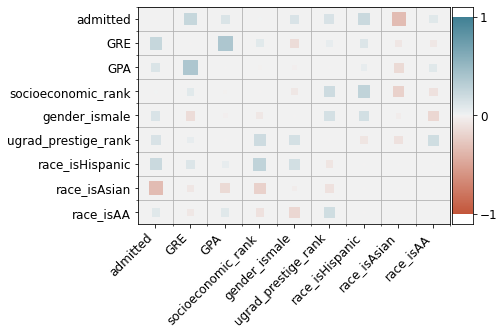

In [13]:
# size+color coded heatmaps from https://github.com/dylan-profiler/heatmaps
corrplot(corrs)
save_fig("correlation_plots",tight_layout=False,bbox_inches='tight')
corrs

## Correlation observations
Note: range of correlations is (-.33 to 0.38)
- admission correlates with common explicit application metrics (GPA, GRE)
- also correlated with prestige of undergrad instition, which is sometimes an explicit metric
- correlated with "being male" at similar strength to GPA
- high correlation between GPA and GRE score -- not suprising
- moderate correlation between socioeconomic and prestige -- also to be expected
- negative correlation between "being male" and GRE scores -- at least in physics applicants, I believe the opposite is true
- moderate negative correlation between "being Asian" and admission; but, also smaller (-) with application metrics

In [14]:
# ['admitted', 'GRE', 'GPA', 'socioeconomic_rank', 'gender_ismale','ugrad_prestige_rank']
GRE_bins = np.linspace(200,800,13)
GPA_bins = np.linspace(2.25,4.0,8)

In [15]:
# split_hist(df=admissions,attribute="GPA",source_cols="gender_ismale", labels=["Female","Male"], bins=GPA_bins, save_suff="_by_gender")

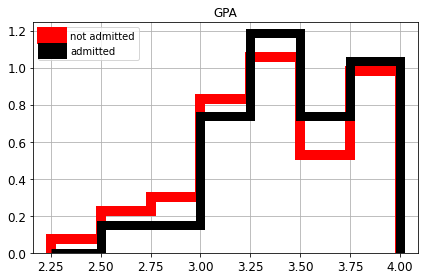

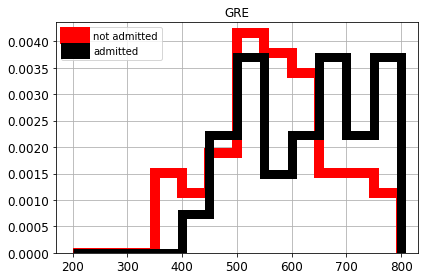

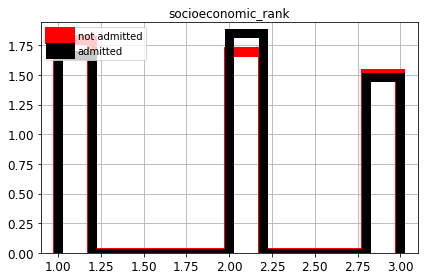

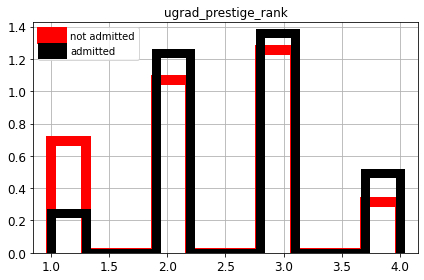

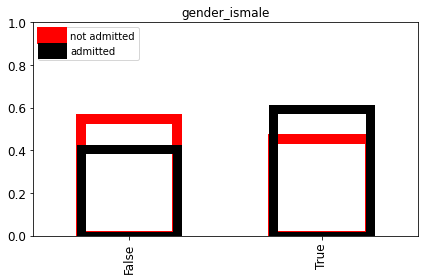

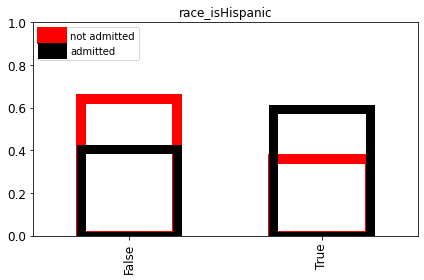

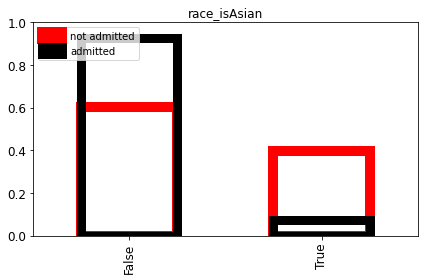

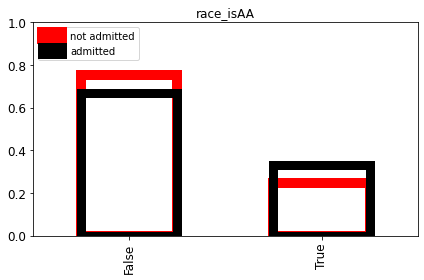

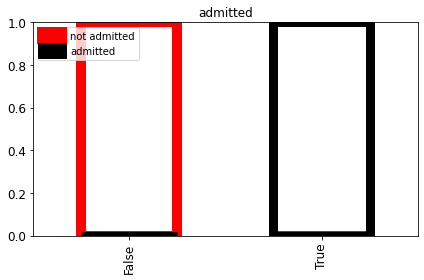

In [20]:
attributes = ["GPA","GRE",'socioeconomic_rank','ugrad_prestige_rank',"gender_ismale", 'race_isHispanic', 'race_isAsian', 'race_isAA','admitted']
bins = [ None for _ in range(len(attributes)) ]
bins[0:1] = [GPA_bins,GRE_bins]
split_hist(df=admissions,attribute=attributes,source_cols='admitted', 
           labels=['not admitted', 'admitted'], colors = ['r','k'], bins=bins, save_suff="_by_admission")

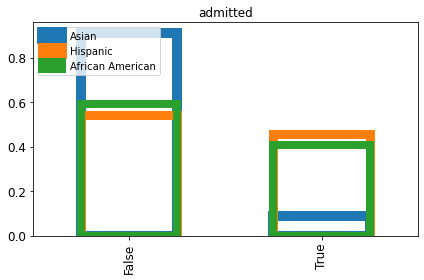

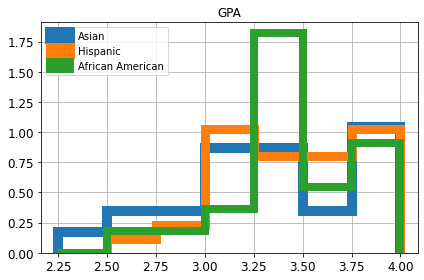

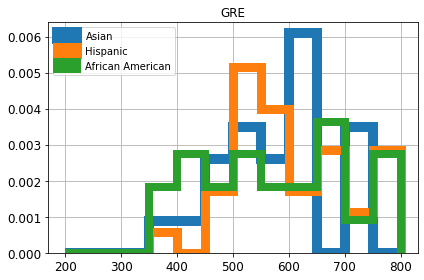

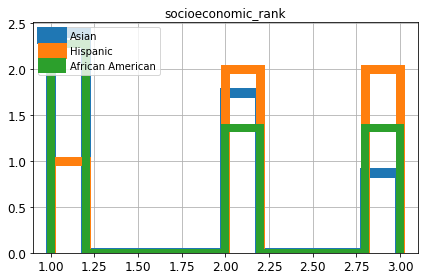

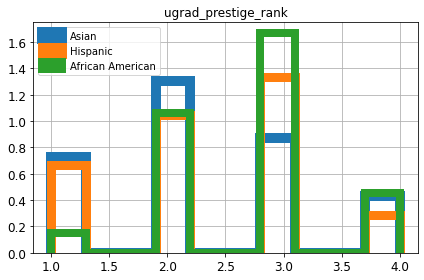

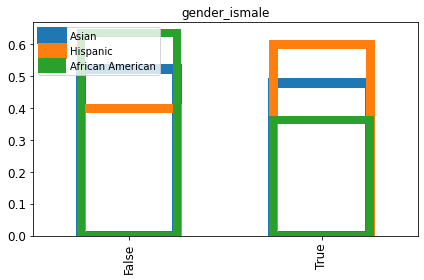

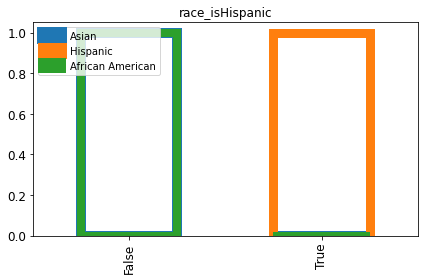

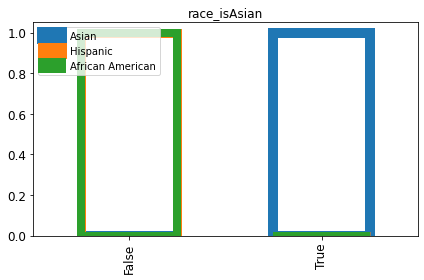

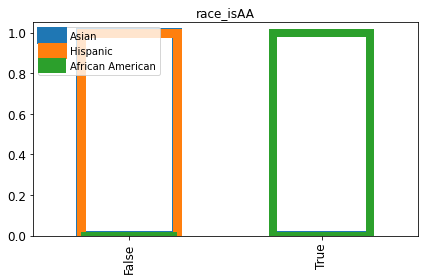

In [17]:
attributes = ['admitted',"GPA","GRE",'socioeconomic_rank','ugrad_prestige_rank',"gender_ismale", 
              'race_isHispanic', 'race_isAsian', 'race_isAA']
bins = [ None for _ in range(len(attributes)) ]
bins[1:2] = [GPA_bins,GRE_bins]
split_hist(df=admissions,attribute=attributes,source_cols=['race_isAsian','race_isHispanic','race_isAA'], labels=['Asian', 'Hispanic', 'African American'], bins=bins, save_suff="_by_race")

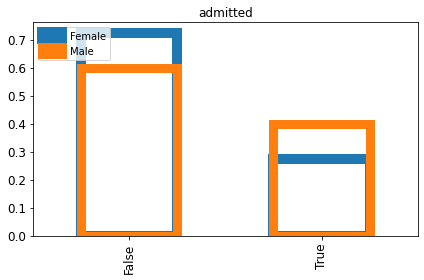

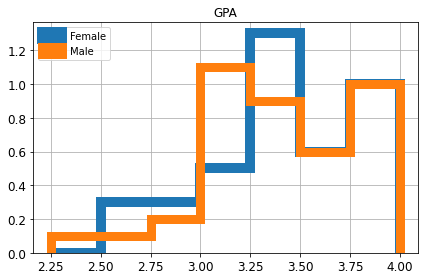

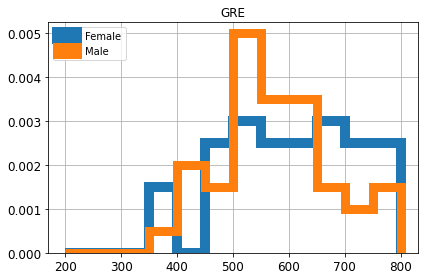

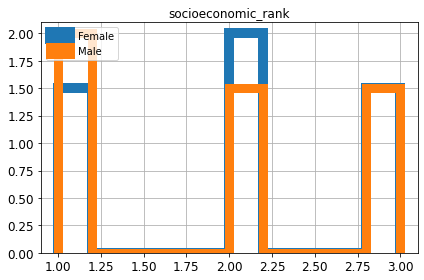

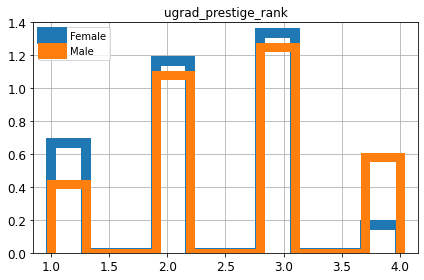

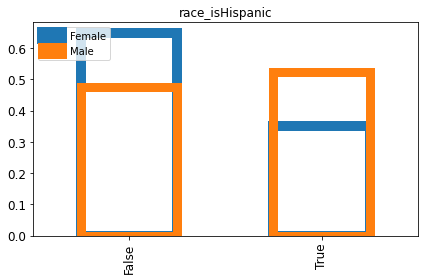

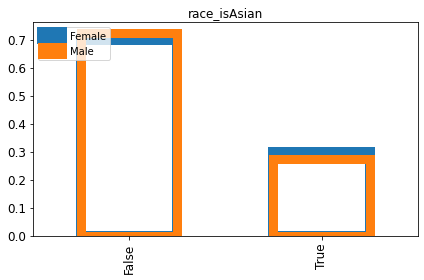

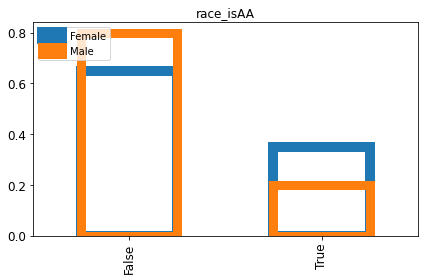

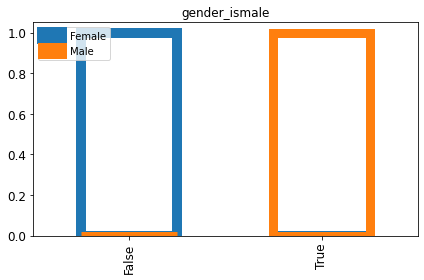

In [18]:
attributes = ['admitted',"GPA","GRE",'socioeconomic_rank','ugrad_prestige_rank', 'race_isHispanic', 'race_isAsian', 'race_isAA',"gender_ismale"]
bins = [ None for _ in range(len(attributes)) ]
bins[1:2] = [GPA_bins,GRE_bins]
split_hist(df=admissions,attribute=attributes,source_cols='gender_ismale', 
           labels=['Female', 'Male'], bins=bins, save_suff="_by_gender")